## First Order Fermi Acceleration

For first order Fermi acceleration, the movement of the scatter center is directed. This is accounted for
using the DirectedFlowScattering module, that adapts the step length based on the direction of the flow of scatter centers - it is harder to travel against the flow, as the scatter probability increases.

The velocity of the scatter centers is different upstream and downstream of the shock. Restricting acceleration modules with corresponding parameters to certain regions using the geometry tools of CRPropa achieves the expected acceleration.


In the following, we demonstrate acceleration in the 'text-book' scenario for first order Fermi acceleration, 
a shock in the $y,z$-plane, located at $x = 0$, and the flow of the scatter center parallel to the $x$ axis. We specify the size of upstream and downstream regions to be 10 kpc and 100 pc, respectively and the acceleration region of infinite size in $y,z$ dimension. The sizes need to be large enough compared to the step-length so that the probability to return to the shock is not affected in order to achieve the expected result. Too small sizes for either region, or also a finite dimension in $y,z$ will reduce the return probability and thus steepen the spectrum.  The infinitely large $y,z$ dimension is achieved by a reflective box of finite size. The actual size of this box in $y$ and $z$ dimensions doesn't matter but should probably not be much smaller than the step-length to avoid multiple reflections in one step.

In [ ]:
import crpropa
scatter_velocity = 0.1 * crpropa.c_light
step_length = 0.5 * crpropa.parsec

flow_direction = crpropa.Vector3d(1., 0, 0) * scatter_velocity
yzsize = 100. * crpropa.parsec


upstream_velocity = flow_direction
upstreamSize = 10000. * crpropa.parsec
upstreamGeometry = crpropa.ParaxialBox(crpropa.Vector3d(-1 * upstreamSize, -.5 * yzsize, -.5 * yzsize),
                         crpropa.Vector3d(upstreamSize, yzsize, yzsize))
upstream_scatter_module = crpropa.DirectedFlowScattering(upstream_velocity, step_length)
upstream = crpropa.RestrictToRegion(upstream_scatter_module, upstreamGeometry)


downstreamSize = 100. * crpropa.parsec
downstream_velocity = flow_direction * 1./4
downstreamGeometry = crpropa.ParaxialBox(crpropa.Vector3d(0, -.5 * yzsize, -.5 * yzsize),
                           crpropa.Vector3d(downstreamSize, yzsize, yzsize))
downstream_scatter_module = crpropa.DirectedFlowScattering(downstream_velocity, step_length)
downstream = crpropa.RestrictToRegion(downstream_scatter_module, downstreamGeometry)
 
simulation = crpropa.ModuleList()
simulation.add(upstream)
simulation.add(downstream)
simulation.add(crpropa.ReflectiveBox(crpropa.Vector3d(-upstreamSize * 2, -yzsize /2, -yzsize /2),
    crpropa.Vector3d(upstreamSize * 2 + downstreamSize * 2, yzsize, yzsize)))

The rest of the simulation is initialized as usual with two sheet observers upstream and downstream. The upstream observer should not detect any particles but acts as a safe guard and cross check.

We inject particles close to the shock in the upstream region with $E_0 = 10^{16}$ eV in this example.


In [1]:
simulation.add(crpropa.SimplePropagation(1E-4 *crpropa.parsec, .5 *crpropa.parsec))
obs1 = crpropa.Observer()
obs1.add(crpropa.ObserverSurface(crpropa.Plane(crpropa.Vector3d(-upstreamSize, 0, 0), crpropa.Vector3d(1., 0, 0))))
obs1.setDeactivateOnDetection(True)
output1 = crpropa.HDF5Output('shock_upstream.h5', crpropa.Output.Event3D)
obs1.onDetection(output1)
simulation.add(obs1)

obs2 = crpropa.Observer()
obs2.add(crpropa.ObserverSurface(crpropa.Plane(crpropa.Vector3d(downstreamSize, 0, 0), crpropa.Vector3d(1., 0, 0))))

obs2.setDeactivateOnDetection(True)
output2 = crpropa.HDF5Output('shock_downstream.h5', crpropa.Output.Event3D)
obs2.onDetection(output2)
simulation.add(obs2)

source = crpropa.Source()
source.add(crpropa.SourcePosition(crpropa.Vector3d(-10. * crpropa.parsec, 0, 0)))
source.add(crpropa.SourceParticleType(crpropa.nucleusId(1, 1)))
source.add(crpropa.SourceEnergy(1E16 * crpropa.eV))
source.add(crpropa.SourceIsotropicEmission())


# Execute simulation
simulation.setShowProgress(True)
simulation.run(source, 10000)
output1.close()
output2.close()

NameError: name 'simulation' is not defined

In [ ]:
import h5py
import numpy as np
import pylab as plt
from scipy import optimize

with h5py.File('shock_downstream.h5', 'r') as data:
    E = data['CRPROPA3']['E'] * 1E18
    bin_edges = 10**np.linspace(15, 21)
    bin_width = bin_edges[1:] - bin_edges[:-1]
    bin_center = bin_edges[:-1] + 0.5 * bin_width

    H = np.histogram(E, bins=bin_edges)

    J = H[0] / bin_width

    dJ = J / np.sqrt(H[0])

    fig = plt.figure(figsize=(6, 6))
    sp = fig.add_subplot(111)
    sp.loglog()
    sp.errorbar(bin_center, J * bin_center**2, xerr=bin_width/2, yerr=dJ * bin_center**2, ls='None')
    sp.set_xlabel('$E$ / eV')
    sp.set_ylim(1e18, 1e21)
    sp.set_ylabel('$J\cdot E^2$ [a.u.]')

yielding the expected $J\propto E^{-2}$ relationship.

Due to the power law nature of the acceleration the simulations may become quite time consuming if large energy gains are of interest. Particle splitting, i.e. inverse thinning, can be used here to reduce the simulation effort. 

The example below shows how that can be done. It is important to take the weights of the candidates into account, which makes small changes in the analysis part necessaray.

In [2]:
import crpropa
scatter_velocity = 0.1 * crpropa.c_light
step_length = 0.5 * crpropa.parsec

flow_direction = crpropa.Vector3d(1., 0, 0) * scatter_velocity
yzsize = 100. * crpropa.parsec


upstream_velocity = flow_direction
upstreamSize = 10000. * crpropa.parsec
upstreamGeometry = crpropa.ParaxialBox(crpropa.Vector3d(-1 * upstreamSize, -.5 * yzsize, -.5 * yzsize),
                         crpropa.Vector3d(upstreamSize, yzsize, yzsize))
upstream_scatter_module = crpropa.DirectedFlowScattering(upstream_velocity, step_length)
upstream = crpropa.RestrictToRegion(upstream_scatter_module, upstreamGeometry)


downstreamSize = 100. * crpropa.parsec
downstream_velocity = flow_direction * 1./4
downstreamGeometry = crpropa.ParaxialBox(crpropa.Vector3d(0, -.5 * yzsize, -.5 * yzsize),
                           crpropa.Vector3d(downstreamSize, yzsize, yzsize))
downstream_scatter_module = crpropa.DirectedFlowScattering(downstream_velocity, step_length)
downstream = crpropa.RestrictToRegion(downstream_scatter_module, downstreamGeometry)
 
simulation = crpropa.ModuleList()
simulation.add(upstream)
simulation.add(downstream)
simulation.add(crpropa.ReflectiveBox(crpropa.Vector3d(-upstreamSize * 2, -yzsize /2, -yzsize /2),
    crpropa.Vector3d(upstreamSize * 2 + downstreamSize * 2, yzsize, yzsize)))

simulation.add(crpropa.SimplePropagation(1E-4 *crpropa.parsec, .5 *crpropa.parsec))
obs1 = crpropa.Observer()
obs1.add(crpropa.ObserverSurface(crpropa.Plane(crpropa.Vector3d(-upstreamSize, 0, 0), crpropa.Vector3d(1., 0, 0))))
obs1.setDeactivateOnDetection(True)
output1 = crpropa.HDF5Output('shock_upstream_splitting.h5', crpropa.Output.Event3D)
output1.enable(crpropa.Output.WeightColumn) #weights needs to be stored
obs1.onDetection(output1)
simulation.add(obs1)

obs2 = crpropa.Observer()
obs2.add(crpropa.ObserverSurface(crpropa.Plane(crpropa.Vector3d(downstreamSize, 0, 0), crpropa.Vector3d(1., 0, 0))))

obs2.setDeactivateOnDetection(True)
output2 = crpropa.HDF5Output('shock_downstream_splitting.h5', crpropa.Output.Event3D)
output2.enable(crpropa.Output.WeightColumn) #weights needs to be stored
obs2.onDetection(output2)
simulation.add(obs2)

# Splitting of candidates with the following parameters
crossingThreshold = 50
numSplits = 3
minWeight = 0.01
counterid = "ParticleSplittingCounter"
#shock_surface = crpropa.Plane(crpropa.Vector3d(0., 0, 0), crpropa.Vector3d(1., 0, 0))
#split = crpropa.ParticleSplitting(shock_surface, crossingThreshold, numSplits, minWeight, counterid)
#simulation.add(split)


source = crpropa.Source()
source.add(crpropa.SourcePosition(crpropa.Vector3d(-10. * crpropa.parsec, 0, 0)))
source.add(crpropa.SourceParticleType(crpropa.nucleusId(1, 1)))
source.add(crpropa.SourceEnergy(1E16 * crpropa.eV))
source.add(crpropa.SourceIsotropicEmission())


# Execute simulation
simulation.setShowProgress(True)
simulation.run(source, 1) #Note the reduced number of primary particles
output1.close()
output2.close()

crpropa::ModuleList: Number of Threads: 8
Run ModuleList
  Started Wed Feb  1 10:32:56 2023 : [ Finished ] 100%    Needed: 00:00:00  - Finished at Wed Feb  1 10:32:56 2023


/tmp/ipykernel_23668/2023190340.py:18: RuntimeWarning: invalid value encountered in true_divide
  dJ = J / np.sqrt(H_count[0])


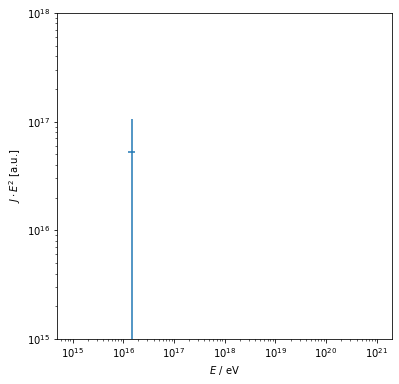

In [4]:
import h5py
import numpy as np
import pylab as plt
from scipy import optimize

with h5py.File('shock_downstream_splitting.h5', 'r') as data:
    E = data['CRPROPA3']['E'] * 1E18
    w = data['CRPROPA3']['weight']
    bin_edges = 10**np.linspace(15, 21)
    bin_width = bin_edges[1:] - bin_edges[:-1]
    bin_center = bin_edges[:-1] + 0.5 * bin_width

    H = np.histogram(E, bins=bin_edges, weights=w)
    H_count = np.histogram(E, bins=bin_edges)

    J = H[0] / bin_width

    dJ = J / np.sqrt(H_count[0])

    fig = plt.figure(figsize=(6, 6))
    sp = fig.add_subplot(111)
    sp.loglog()
    sp.errorbar(bin_center, J * bin_center**2, xerr=bin_width/2, yerr=dJ * bin_center**2, ls='None')
    sp.set_xlabel('$E$ / eV')
    sp.set_ylim(1e15, 1e18)
    sp.set_ylabel('$J\cdot E^2$ [a.u.]')

In [16]:
with h5py.File('shock_downstream_splitting.h5', 'r') as data:
    print([a for a in (data['CRPROPA3']).attrs])

['EnergyScale', 'LengthScale', 'OutputType', 'SEED_000', 'SEED_001', 'SEED_002', 'SEED_003', 'SEED_004', 'SEED_005', 'SEED_006', 'SEED_007', 'Version']


Note the different normalizations of the flux due the difference in the number of injected particles.